# Поиск "эгоистичных" чисел для метода середины квадрата

В [предыдущем видео]() я рассказал, как [фон Нейман](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%B9%D0%BC%D0%B0%D0%BD,_%D0%94%D0%B6%D0%BE%D0%BD_%D1%84%D0%BE%D0%BD) предложил первый генератор псевдослучайных чисел.

Идея проста: берем для начала любое четырехзначное число. Возводим его в квадрат. Если цифр меньше 8, дополняем слева нулями. Теперь выделяем 4 средние цифры. Получилось первое число случайной последовательности. Далее повторяем процедуру необходимое число раз.

Фон Нейман предполагал, что цепочка чисел будет случайным образом равномерно заполнять интервал четырехзначных чисел без предсказуемых повторений, но, к сожалению, оказался неправ.

Для некоторых последовательностей такой генератор начинает зацикливаться и становится предсказуемым. Существуют даже такие "эгоистичные" числа, которые  "воспроизводят" только сами себя. То есть при их возвезедении в квадрат в середине 8-значного числа будет исходное 4-х значное.

```XXXX^2 = YYXXXXYY```

Давайте найдем такие числа с помощью Python.

## Предварительные сведения

Напомним, как дополнять строки в Python до нужного количества знаков. Для этого можно использовать метод `.rjust()`. Первый аргумент — общее число символов, второй — заполняющий символ:

In [1]:
'123'.rjust(8, '0')

'00000123'

Заполнение нулями довольно распространенная операция, поэтому есть специальный метод `.zfill()`:

In [18]:
'123'.zfill(8)

'00000123'

Вспомним так же про срезы:

In [2]:
'01234567'[2:-2]

'2345'

## Пишем функцию

Рассмотрим самое полное представление четырехзначных чисел — от `0000` до `9999`, ведь генератор может начать повторяться и в середине работы алгоритма.

In [3]:
def find_egoists():
    egoists = []
    for i in range(10**4):
        s = str(i**2).zfill(8)
        if int(s[2:-2]) == i:
            egoists.append(i)
    return egoists
            
find_egoists()

[0, 100, 2500, 3792, 7600]

Проверим корректность работы функции — сравним число и его квадрат в 8-значном представлении:

In [4]:
for i in find_egoists():
    print(str(i).zfill(4),
          str(i**2).zfill(8))

0000 00000000
0100 00010000
2500 06250000
3792 14379264
7600 57760000


# Сравнение работы генераторов псевдослучайных чисел

Сравним между собой самый первый, нерабочий генератор случайных чисел и современный, используемый по умолчанию в Python — [Вихрь Мерсенна]( https://ru.wikipedia.org/wiki/%D0%92%D0%B8%D1%85%D1%80%D1%8C_%D0%9C%D0%B5%D1%80%D1%81%D0%B5%D0%BD%D0%BD%D0%B0), а также [PCG](https://en.wikipedia.org/wiki/Permuted_congruential_generator)-генератор, применяемый в Numpy.

In [5]:
def neumann_gen(size:int, seed:int):
    '''Принимает число от 0 до 9999
    и возвращает случайное число
    по методу середины квадрата'''
    results = []
    for i in range(size):
        square = seed**2
        square_str = str(square).zfill(8)
        seed = int(square_str[2:-2])        
        results.append(seed)        
    return results

Теперь возьмем идентичный размер выборки запустим генератор и сравним заполнение плоскости для него и других сторонних библиотек:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
size = 10**5

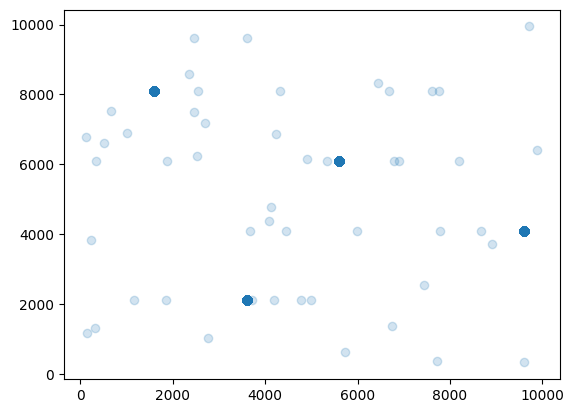

In [7]:
x = neumann_gen(size=size, seed=1111)
y = neumann_gen(size=size, seed=5555)
plt.scatter(x, y, alpha=0.2)
plt.show()

Результат преобразования Фурье

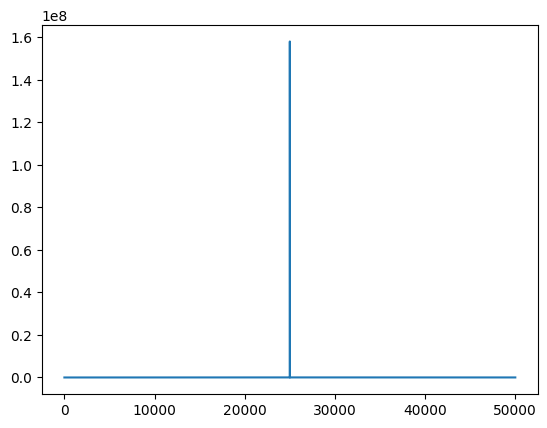

In [8]:
from scipy.fft import rfft, rfftfreq
yf = rfft(y)

plt.plot(np.abs(yf)[1:])
plt.show()

# Модуль стандартной библиотеки `random`

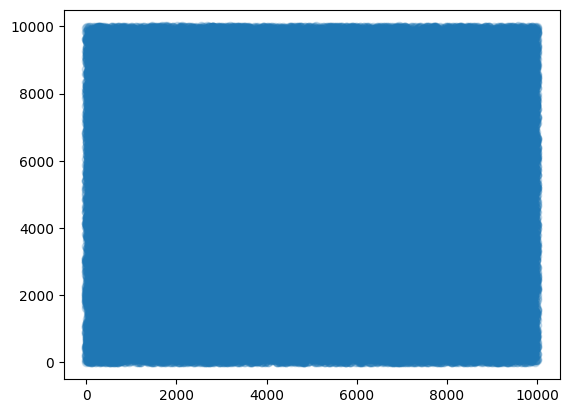

In [9]:
import random

x = [random.randrange(0, 10**4) for i in range(size)]
y = [random.randrange(0, 10**4) for i in range(size)]
plt.scatter(x, y, alpha=0.2)
plt.show()

Результат преобразования Фурье

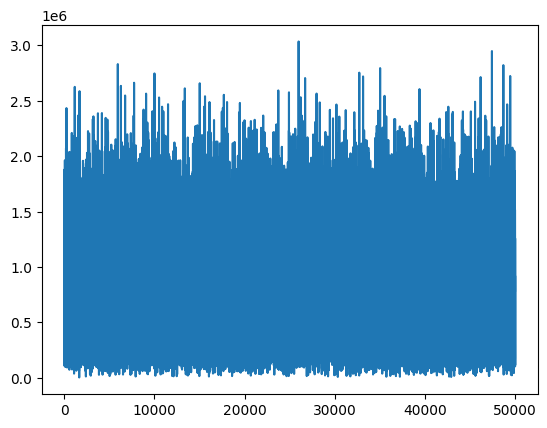

In [10]:
yf = rfft(y)

plt.plot(np.abs(yf)[1:])
plt.show()

# Библиотека `numpy`

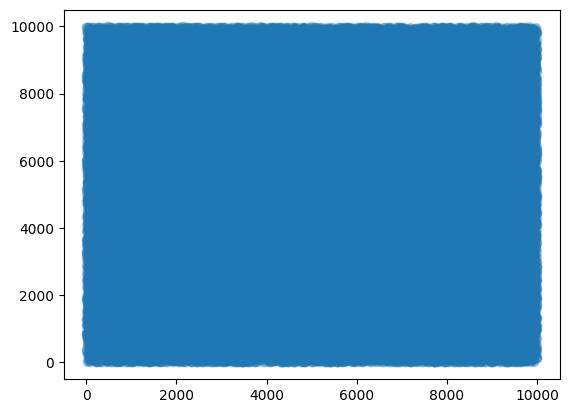

In [11]:
import numpy as np
x = np.random.randint(0, 1e4, size=size)
y = np.random.randint(0, 1e4, size=size)
plt.scatter(x, y, alpha=0.2)
plt.show()

Результат преобразования Фурье

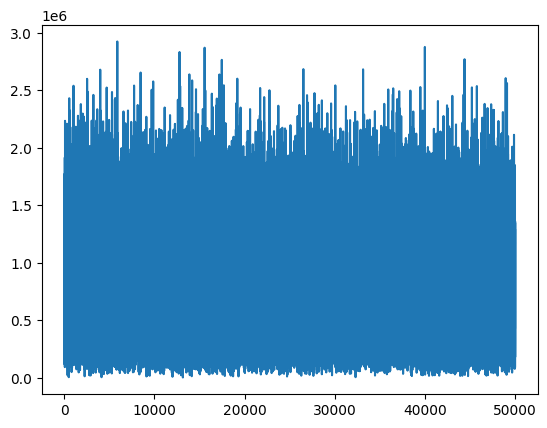

In [12]:
yf = rfft(y)

plt.plot(np.abs(yf)[1:])
plt.show()

# Как влияет инициализация

Сравним теперь длины генерируемой последовательности при различной инициализациии, намеренно останавливая генератор, когда в последовательности появляется уже встречавшееся ранее число.

In [13]:
def neumann_gen_length(seed:int):
    results = []
    while True:
        square = seed**2
        square_str = str(square).zfill(8)
        seed = int(square_str[2:-2])
        if seed in results:
            break
        else:
            results.append(seed)        
    return len(results)

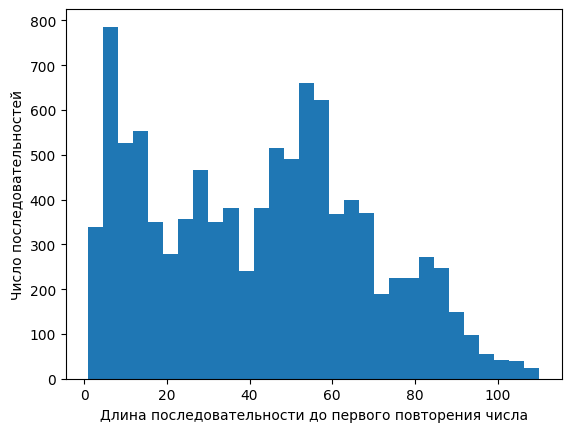

In [14]:
x = range(10**4)
y = [neumann_gen_length(seed=i) for i in x]
plt.hist(y, bins=30)
plt.xlabel('Длина последовательности до первого повторения числа')
plt.ylabel('Число последовательностей')
plt.show()

In [15]:
max(y)

110

Как видим, даже в лучших случаях повторение наступает через 110 элементов последовательности. То, что числа в последовательности повторяются — совершенно нормально, но то, что максимальное число цепочки так невелико — плохой показатель работы алгоритма.

Сравним с современными генераторами.

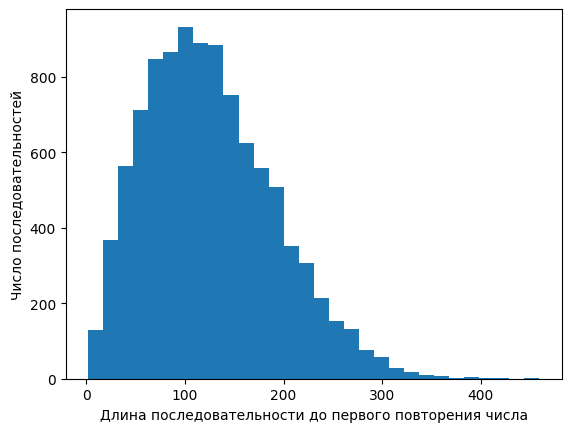

In [16]:
def random_gen_length():
    results = []
    while True:
        res = random.randrange(0, 10**4)
        if res in results:
            break
        else:
            results.append(res)        
    return len(results)


x = range(10**4)
y = [random_gen_length() for i in x]
plt.hist(y, bins=30)
plt.xlabel('Длина последовательности до первого повторения числа')
plt.ylabel('Число последовательностей')
plt.show()

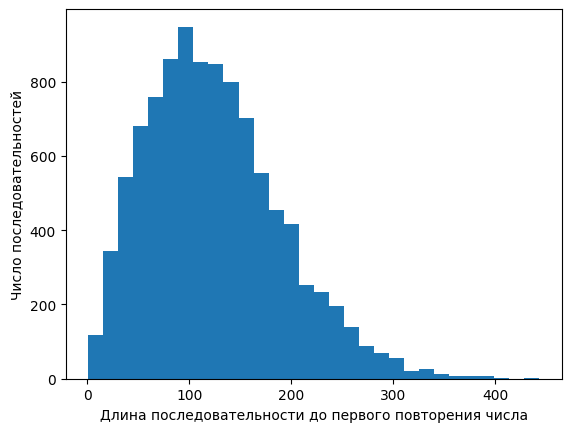

In [17]:
def numpy_gen_length():
    results = []
    while True:
        res = np.random.randint(10**4)
        if res in results:
            break
        else:
            results.append(res)        
    return len(results)


x = range(10**4)
y = [numpy_gen_length() for i in x]
plt.hist(y, bins=30)
plt.xlabel('Длина последовательности до первого повторения числа')
plt.ylabel('Число последовательностей')
plt.show()